# COGS 108 - Final Project 

# Overview

Location and distance are very important factors in the choosing of a place to go.  When someone wants to go somewhere, we often check upon reviews to see if it worth their time.  This can be said for many locations, but the focus here is on Public Parks.  Since distance is a consideration on what park people choose to attend, I wanted test that assumption of distance being related to the park's review.  After an analysis of this topic, the data does not show much of a relationship between the locational distance of a park and its rating.

# Name & GitHub ID

- Name: Patrick Pajarillaga
- GitHub Username: Patrick-Pajarillaga
- PID: A14580692

# Research Question

Is there a relationship between the distance of a park in San Diego County from the San Diego city center and how rated it is on Yelp?

## Background and Prior Work

San Diego county itself encoupasses an area of 4,526 mi², starting from the US-Mexico border to the South and the city of San Clemente to the North. San Diego is considered to be an area that takes pride in its parks and park facilities.  With well known institutions such as Balboa Park and Kate Sessions, there are an endless variety of them within the county.  What does vary is how highly regarded some of these parks are when noted on different review sites.

There are many review sites that provide reviews for different parks based in San Diego county.  These often include: Yelp, Trip Advisor, and Google Reviews.  For the purposes of this analysis, Yelp will be used.  Yelp reviews contain a system that is based on a 0 to 5 scale (5 Star System).  The higher the rating, the more liked and well recieved the park/location is based on a multitude of users within the app.

One similar study done is based on an article written by Matt Murphy called, "How Does Location Influence Beer Ratings?".  In this article he found that the location of where the brew was related to what review a person gave on that specific beer.  While this study does not have park and recreation data, it does do a relationship analysis between a rating and a location, which is similar to the study being done here.

References:
- https://beergraphs.com/bg/11-how-does-location-influence-beer-ratings/
- https://www.sandiego.gov/parks-and-recreation
- https://www.sandiegocounty.gov/economicroundtable/docs/ertfact2014.pdf
- https://www.yelp.com/

# Hypothesis


I believe that there is no relationship between the distance of a park compared to its rating on Yelp. Traveling 
some distance would not adversely affect how one would think about a park; people will judge it based on other characteristics 
such as its cleanliness, and or its appearance.  In terms of null hypothesis and alternative hypothesis; the H0: There is no relationship between distance and rating (slope = 0), Ha: There is a relationship between distance and rating. (slope != 0)

# Dataset(s)

- Dataset Name: San Diego Parks Yelp Data
- Link to Dataset: https://www.yelp.com/
- Note: Hand Curated Dataset using Yelp API created by Prof Ellis.
- Num of Observations: 833
- Num of Columns: 10

This is the main dataset I will be using to answer the above research question.  The specific features to be used in this dataset would be the ratings, the longitude, and the latitude columns to perform my linear regression analysis.

*Not Really a Dataset, but a DataPoint Used
- Datapoint Name: San Diego, CA, USA Geographic Information
- Link to DataPoint: https://www.latlong.net/place/san-diego-ca-usa-7073.html

This is not to be considered as a dataset, but regardless it is data nonetheless.  This point is the center of San Diego used to calculate the distance between the parks and San Diego center.

# Setup

In [24]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from patsy import dmatrices
import statsmodels.api as sm
import math
import numpy as np

# Data Cleaning

The data itself does not need too much cleaning, all it needs are conversions so that distance calculations can be made.  The longitudinal and latitudinal values can be made into Point Objects for easier distance calculations to SD center.

In [2]:
#Load in the Dataset
yelp = pd.read_csv("data/yelp_SD_parks.csv")
yelp.head()

,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed
0,Balboa Park,"1549 El Prado San Diego, CA 92101",1.619239e+10,9M_FW_-Ipx93I36w-_ykBg,https://www.yelp.com/biz/balboa-park-san-diego...,5.0,2105,-117.153150,32.734502,False
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",NaN,3AEHjqNrTmggA6G9VdhQfg,https://www.yelp.com/biz/civita-park-san-diego...,4.5,46,-117.147278,32.778315,False
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",1.619233e+10,3unbJeYrn1RmInZGmjp80g,https://www.yelp.com/biz/waterfront-park-san-d...,4.5,242,-117.172479,32.721952,False
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",NaN,PvHxIYrmaiFKdWUDTMDzcg,https://www.yelp.com/biz/trolley-barn-park-san...,4.5,102,-117.143789,32.762463,False
4,Bay View Park,"413 1st St Coronado, CA 92118",NaN,6IF4VB9-fkv_F-LBvG8ppQ,https://www.yelp.com/biz/bay-view-park-coronad...,5.0,42,-117.178967,32.701785,False


In [3]:
#Check for any empty values in dataset
yelp.isna()

,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed
0,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
828,False,False,False,False,False,False,False,False,False,False
829,False,False,False,False,False,False,False,False,False,False
830,False,False,False,False,False,False,False,False,False,False
831,False,False,False,False,False,False,False,False,False,False


In [4]:
#Covnert Coordinates into Points so that distance can be calculated easier
crs = {'init': 'espg:4326'}
geometry = [Point(xy) for xy in zip(yelp['longitude'], yelp['latitude'])]
yelp_geo = gpd.GeoDataFrame(yelp, geometry=geometry, crs="EPSG:4326")
yelp_geo.head()

,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed,geometry
0,Balboa Park,"1549 El Prado San Diego, CA 92101",1.619239e+10,9M_FW_-Ipx93I36w-_ykBg,https://www.yelp.com/biz/balboa-park-san-diego...,5.0,2105,-117.153150,32.734502,False,POINT (-117.15315 32.73450)
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",NaN,3AEHjqNrTmggA6G9VdhQfg,https://www.yelp.com/biz/civita-park-san-diego...,4.5,46,-117.147278,32.778315,False,POINT (-117.14728 32.77831)
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",1.619233e+10,3unbJeYrn1RmInZGmjp80g,https://www.yelp.com/biz/waterfront-park-san-d...,4.5,242,-117.172479,32.721952,False,POINT (-117.17248 32.72195)
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",NaN,PvHxIYrmaiFKdWUDTMDzcg,https://www.yelp.com/biz/trolley-barn-park-san...,4.5,102,-117.143789,32.762463,False,POINT (-117.14379 32.76246)
4,Bay View Park,"413 1st St Coronado, CA 92118",NaN,6IF4VB9-fkv_F-LBvG8ppQ,https://www.yelp.com/biz/bay-view-park-coronad...,5.0,42,-117.178967,32.701785,False,POINT (-117.17897 32.70179)


In [5]:
#Crate a Point Object that holds Center of SD
center_SD = Point(-117.161087, 32.715736)

#Helper Function to Calculate distance from Center to Park
def distance_to_center(point):
    return center_SD.distance(point)

#Calculate the distance for all the parks in dataset
yelp_geo['distance'] = yelp_geo['geometry'].apply(distance_to_center)
yelp_geo.head()

,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed,geometry,distance
0,Balboa Park,"1549 El Prado San Diego, CA 92101",1.619239e+10,9M_FW_-Ipx93I36w-_ykBg,https://www.yelp.com/biz/balboa-park-san-diego...,5.0,2105,-117.153150,32.734502,False,POINT (-117.15315 32.73450),0.020375
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",NaN,3AEHjqNrTmggA6G9VdhQfg,https://www.yelp.com/biz/civita-park-san-diego...,4.5,46,-117.147278,32.778315,False,POINT (-117.14728 32.77831),0.064084
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",1.619233e+10,3unbJeYrn1RmInZGmjp80g,https://www.yelp.com/biz/waterfront-park-san-d...,4.5,242,-117.172479,32.721952,False,POINT (-117.17248 32.72195),0.012978
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",NaN,PvHxIYrmaiFKdWUDTMDzcg,https://www.yelp.com/biz/trolley-barn-park-san...,4.5,102,-117.143789,32.762463,False,POINT (-117.14379 32.76246),0.049826
4,Bay View Park,"413 1st St Coronado, CA 92118",NaN,6IF4VB9-fkv_F-LBvG8ppQ,https://www.yelp.com/biz/bay-view-park-coronad...,5.0,42,-117.178967,32.701785,False,POINT (-117.17897 32.70179),0.022679


# Data Analysis & Results

First we check the distributions of distance and reviews, and remove any outliers

Text(0, 0.5, 'Frequency')

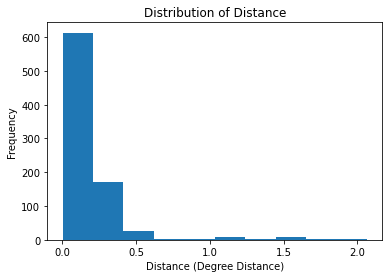

In [34]:
#Remove any serious outliers on the data
yelp_geo = yelp_geo[yelp_geo["distance"] < 1000]

#dist for distance
plt.hist(x=yelp_geo["distance"])
plt.title("Distribution of Distance")
plt.xlabel('Distance (Degree Distance)')
plt.ylabel('Frequency')

The distribution of distance seems to be highly skewed to the right, so we apply a log transformation to make the distribution more normally distributed

Text(0, 0.5, 'Frequency')

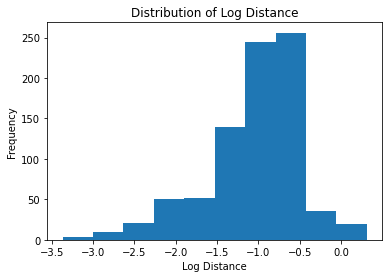

In [33]:
#Apply log transform to get an almost normal distribution
yelp_geo["distance_log"] = yelp_geo["distance"].apply(math.log10)
plt.hist(x=yelp_geo["distance_log"])
plt.title("Distribution of Log Distance")
plt.xlabel('Log Distance')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

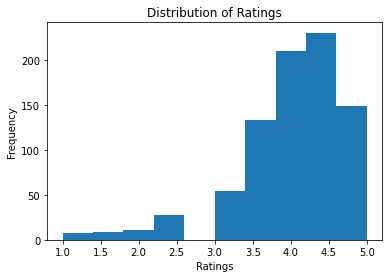

In [32]:
plt.hist(x=yelp_geo["rating"])
plt.title("Distribution of Ratings")
plt.xlabel('Ratings')
plt.ylabel('Frequency')

Although there is a left skew, we can maintain the ratings as they are since it is not as skewwed as distance.

Text(450.78343014768444, 0.5, 'Latitude')

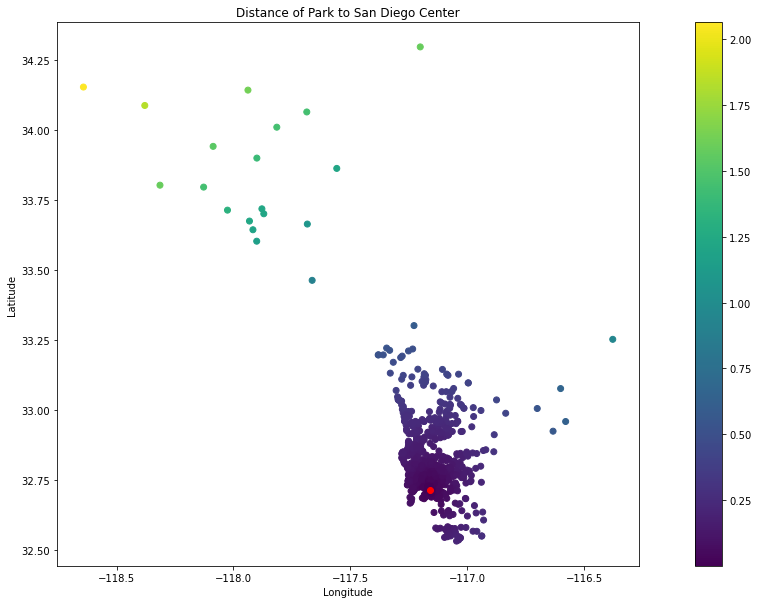

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Distance of Park to San Diego Center")
yelp_geo.plot(ax=ax,column='distance', legend=True)
plt.plot(-117.161087, 32.715736, color='red', marker='o')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

This is just a side visualization used to picture the distance away the parks are from the city center laid out using the actual coordinates of the parks.

Then we check the scatterplot between Rating and Log Distance to see any irregulatiries and use a visual check to see any linear relationship

Text(0.5, 1.0, 'Log Distance vs. Rating of SD Park')

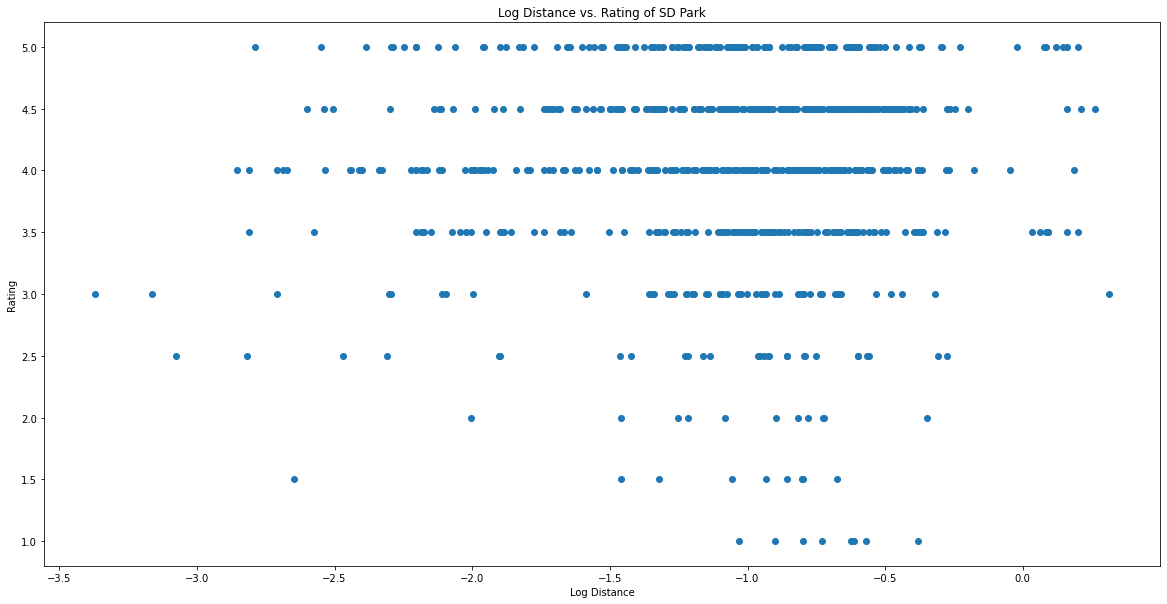

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
s = plt.scatter(x=yelp_geo['distance_log'], y=yelp_geo['rating'])
ax.set_xlabel('Log Distance')
ax.set_ylabel('Rating')
plt.title("Log Distance vs. Rating of SD Park")

Afterwards we perform a linear regression analysis using patsy and statsmodels to get the slope, intercept, p-value, and std error.

In [23]:
#Perform Linear Regression on the Dataset between distance log and rating
outcome, predictor = dmatrices('rating ~ distance_log', yelp_geo)

mod = sm.OLS(outcome, predictor)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.131
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.288
Time:                        07:16:26   Log-Likelihood:                -990.58
No. Observations:                 832   AIC:                             1985.
Df Residuals:                     830   BIC:                             1995.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.0945      0.059     69.967   

Since the p-value of distance_log seems to be a significant number above normal test p-values (p = 0.05, 0.1, etc) and that the slope is almost near 0 (std error helps to provide the range of values the slope can be), it can be concluded that since we do not reject the Null Hyposis, there seems to be no relationship between distance and ratings.

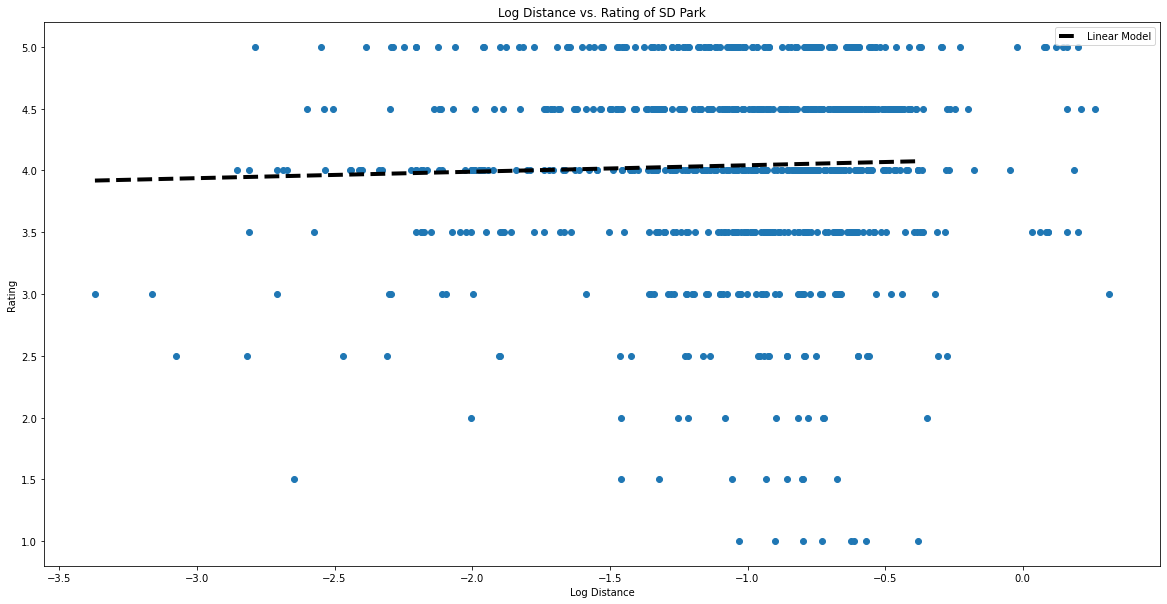

In [35]:
fig, ax = plt.subplots(figsize=(20, 10))
s = plt.scatter(x=yelp_geo['distance_log'], y=yelp_geo['rating'])
ax.set_xlabel('Log Distance')
ax.set_ylabel('Rating')
plt.title("Log Distance vs. Rating of SD Park")

xs = np.arange(yelp_geo['distance_log'].min(), yelp_geo['distance_log'].max())
ys = 4.0945 + 0.0523 * xs
plt.plot(xs, ys, '--k', linewidth=4, label="Linear Model")
plt.legend()

Here I am just plotting a line through the data using the values from the linear regression to just visualize how that line fits through that data

# Ethics & Privacy

The data itself was collected through Yelp and that there is ethical concerns there in that the Yelp data can be used to trace back to indiviual users. However, the dataset of Yelp reviews only shows the average rating of the location, and not any personal identifications, so privacy is maintaned there.  There are other concerns that of use of this analysis might be extrapolated to other counties in California/US, but there is no guarantee that this model would suit other counties, since there are differences in population density, landscape, and much more.  Mitigating this problem requires clear indications such as warnings on the results that signify that this should only be used for San Diego, not for other areas like Orange County.
Another consideration to make is that this is open-source data to be used.  However, if this data is used in a commerical sense, then there is problems to face there, but this is for an educational purpose so there is no issues.

# Conclusion & Discussion

Based on the analysis, I can conclude that the distance away a San Diego park is, is not reflective in the ratings/view of the park itself.

The data from yelp reviews showcased fairly normal distributions with slight skews and when plotted against each other showed no irregularities. Then, by using a linear regression model, that regression showcased that there is no relationship between these two factors based upon p-value testing and an analysis between the slope and the standard error.

A limitation this project holds is that this model can really only be used for San Diego, since it only used San Diego data not the data of other counties.  Another thing is that the reviews themselves are heavily distributed towards the 4 - 5 range, and that can be attributed to the nature of giving a review on Yelp.  Most cases, people that are satisfied give a location the 5 star rating.  This is not reflective of a true rating of the location, since 5 would indicate the highest, but if they are just satisfied they should only give something more relfective based on the scale.